## Overdensity probability distributions

In this notebook we plot the distribution of galaxy overdensities calculated at different redshifts and with differing aperture configurations.

In [1]:
import pandas as pd
import numpy as np

import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from methods import bhattacharyya
from methods import plotit
from methods import overdensity_cylinder
from methods import factor_h
from methods import z_distort
from methods import get_protoclusters

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
out_directory ='output/'

h = 0.673
L = 480.279 / h # box side length

# N = 200000    # number of random regions

Load galaxy dataframes

In [2]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97','8p22','8p93','9p72']
zees = [float(z.replace('p','.')) for z in redshifts]

gals_sfr = [None] * len(redshifts)
gals_mstar = [None] * len(redshifts)

for i, z in enumerate(redshifts):
    print i, z
    
    gals_sfr[i] = pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,z), 
                              skiprows=122, skipfooter=1, engine='python')
    
    gals_mstar[i] = pd.read_csv('%shenriques2015a_z%s_stellarMass_r200.csv'%(directory,z), 
                                skiprows=122, skipfooter=1, engine='python')

0 2p07
1 3p10
2 3p95
3 5p03
4 5p92
5 6p97
6 8p22
7 8p93
8 9p72


Factor out $h$ and apply $z$-distortion

In [3]:
for i, z in enumerate(zees):
    for gals in [gals_sfr, gals_mstar]:
        gals[i] = z_distort(factor_h(gals[i], h), z, L)

#         print "Filling in NaN values..."
        gals[i].ix[np.isnan(gals[i]['z0_haloId']), 'z0_haloId'] = -1
        gals[i].ix[np.isnan(gals[i]['z0_centralId']), 'z0_centralId'] = -1
        gals[i].ix[np.isnan(gals[i]['z0_central_mcrit200']), 'z0_central_mcrit200'] = 0
    

## Calculate $\delta_{\mathrm{gal}}$

Calculate and save dgal for paper plots

Find $D_{B}$ for all parameter permutations to assess the best for protocluster identification

In [ ]:
N = int(1e5)
coods = pd.DataFrame(np.random.rand(N,3) * L, columns=['zn_x','zn_y','zn_z'])  # generate random regions

stats = {z: {sel: {r: {'clim': None, 'plim': None, 'DB': None} for r in [6,10,14]} \
             for sel in ['mstar','mstar10','sfr','sfr5']} for z in zees}

In [6]:
for i, z in enumerate(zees[1:]):
    
    for j, (gals, glabel) in enumerate(zip([gals_mstar[i], gals_mstar[i].loc[gals_mstar[i]['zn_stellarMass'] > 1],
                              gals_sfr[i], gals_sfr[i].loc[gals_sfr[i]['zn_sfr'] > 5]],
                                 ['mstar','mstar10','sfr','sfr5'])):
    
        for r in [6,10,14]:
            
            pcs = get_protoclusters(gals, L)
            out_stats = overdensity_cylinder(gals, pcs['coods'], L=L, R=r, dc=r, pc_stats=True)  # pc stats
            
            stats[z][glabel][r]['clim'] = round(np.percentile(out_stats[:,1], 5), 3)
            stats[z][glabel][r]['plim'] = round(np.percentile(out_stats[:,2], 5), 3)
            
            out_stats = overdensity_cylinder(gals, coods, L=L, R=r, dc=r, pc_stats=True)  # all coods stats
            
            stats[z][glabel][r]['DB'] = plotit(1, out_stats, axb=1, N=18, clim=stats[z][glabel][r]['clim'],
                                              plim=stats[z][glabel][r]['plim'], mlim=7.3e4, noplot=True)[0]
            
            
            print z, glabel, r, ":", stats[z][glabel][r]
            

3.1 mstar 6 : {'clim': 0.418, 'DB': 0.795, 'plim': 0.674}
3.1 mstar 10 : {'clim': 0.832, 'DB': 0.758, 'plim': 0.367}


KeyboardInterrupt: 

In [9]:
# pcl.dump(stats, open('od_stats.p','w'))
stats = pcl.load(open('od_stats.p', 'r'))

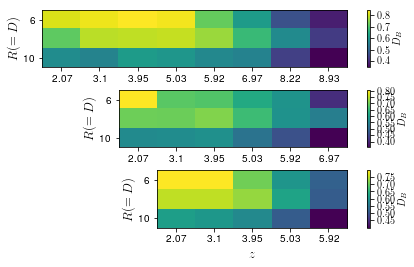

In [146]:
fig = plt.figure(figsize=(7,4))

gs1 = gridspec.GridSpec(3, 1)
gs1.update(hspace=0.4)

ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])

cax1 = ax1.imshow(np.array([[stats[z]['sfr'][r]['DB'] for z in zees[:8]] for r in [6,10,14]]), aspect=0.5)
cax2 = ax2.imshow(np.array([[stats[z]['sfr5'][r]['DB'] for z in zees[:6]] for r in [6,10,14]]), aspect=0.5)
cax3 = ax3.imshow(np.array([[stats[z]['mstar'][r]['DB'] for z in zees[:5]] for r in [6,10,14]]), aspect=0.5)
# ax4.imshow(np.log10(np.array([[stats[z]['mstar10'][r]['DB'] for z in zees[:2]] for r in [6,10,14]])))

for ax, cax in zip([ax1,ax2,ax3], [cax1,cax2,cax3]):
    ax.set_xticklabels(np.roll(zees, 1))
    ax.set_yticklabels(['None',6,10,14])
    ax.set_ylabel('$R (= D)$', size=13)
    fig.colorbar(cax, ax=ax, label='$D_{B}$')
    
    
ax3.set_xlabel('$z$', size=13)

# plt.savefig(out_directory+'db_map.png', bbox_inches='tight', dpi=300)

In [14]:


# out_stats_sfr_z3p95_r10_dc10 = overdensity_cylinder(gals_sfr[2], coods, L=L, R=10, dc=10, pc_stats=True)
# out_stats_sfr_z3p95_r6_dc6 = overdensity_cylinder(gals_sfr[2], coods, L=L, R=6, dc=6, pc_stats=True)
# out_stats_sfr_z3p95_r14_dc14 = overdensity_cylinder(gals_sfr[2], coods, L=L, R=14, dc=14, pc_stats=True)
# out_stats_sfr_z3p95_r6_dc14 = overdensity_cylinder(gals_sfr[2], coods, L=L, R=6, dc=14, pc_stats=True)
# out_stats_sfr_z3p95_r10_dc14 = overdensity_cylinder(gals_sfr[2], coods, L=L, R=10, dc=14, pc_stats=True)
# out_stats_sfr_z3p10_r10_dc10 = overdensity_cylinder(gals_sfr[1], coods, L=L, R=10, dc=10, pc_stats=True)
# out_stats_sfr_z5p03_r10_dc10 = overdensity_cylinder(gals_sfr[3], coods, L=L, R=10, dc=10, pc_stats=True)
# out_stats_mstar_z2p07_r10_dc10 = overdensity_cylinder(gals_mstar[0], coods, L=L, R=10, dc=10, pc_stats=True)
# out_stats_mstar10_z2p07_r10_dc10 = overdensity_cylinder(gals_mstar[0].loc[gals_mstar[0]['zn_stellarMass'] > 1]\
#                                                         .reset_index(drop=True), coods, L=L, 
#                                                         R=10, dc=10, pc_stats=True)


# pcl.dump([out_stats_sfr_z3p95_r10_dc10, out_stats_sfr_z3p95_r6_dc6, out_stats_sfr_z3p95_r14_dc14,
#          out_stats_sfr_z3p95_r6_dc14, out_stats_sfr_z3p95_r10_dc14, out_stats_sfr_z3p10_r10_dc10,
#          out_stats_sfr_z5p03_r10_dc10, out_stats_mstar_z2p07_r10_dc10, out_stats_mstar10_z2p07_r10_dc10], 
#          open('out_stats.p','w'))

out_stats_sfr_z3p95_r10_dc10, out_stats_sfr_z3p95_r6_dc6, out_stats_sfr_z3p95_r14_dc14,\
out_stats_sfr_z3p95_r6_dc14, out_stats_sfr_z3p95_r10_dc14, out_stats_sfr_z3p10_r10_dc10,\
out_stats_sfr_z5p03_r10_dc10, out_stats_mstar_z2p07_r10_dc10, out_stats_mstar10_z2p07_r10_dc10 = \
    pcl.load(open('out_stats.p','r'))

Find $C_{lim}$ and $P_{lim}$

In [18]:
gals = [gals_sfr[2], gals_sfr[2], gals_sfr[2], gals_sfr[2], gals_sfr[2], gals_sfr[1], gals_sfr[3],
        gals_mstar[0], gals_mstar[0].loc[gals_mstar[0]['zn_stellarMass'] > 1].reset_index(drop=True)]

R = [10, 6, 14, 6, 10, 10, 10, 10, 10]
dc = [10, 6, 14, 14, 14, 10, 10, 10, 10]

clim = [None] * len(gals)
plim = [None] * len(gals)

for i, (gal, r, delc) in enumerate(zip(gals, R, dc)):
    print "%s, R:"%i, r, "dc:", delc
    
    pcs = get_protoclusters(gal, L)
    out_stats = overdensity_cylinder(gal, pcs['coods'], L=L, R=r, dc=delc, pc_stats=True)
    
    print "Clim: %.2f %.2f %.2f"%(np.percentile(out_stats[:,1], 95), np.median(out_stats[:,1]), 
                                  np.percentile(out_stats[:,1], 5))
    
    print "Plim: %.2f %.2f %.2f\n"%(np.percentile(out_stats[:,2], 95), np.median(out_stats[:,2]), 
                                  np.percentile(out_stats[:,2], 5))
    
    clim[i] = np.percentile(out_stats[:,1], 5)
    plim[i] = np.percentile(out_stats[:,2], 5)
    

0, R: 10 dc: 10
Clim: 1.00 0.98 0.73
Plim: 0.91 0.71 0.50

1, R: 6 dc: 6
Clim: 0.88 0.66 0.30
Plim: 1.00 0.95 0.83

2, R: 14 dc: 14
Clim: 1.00 1.00 0.95
Plim: 0.71 0.44 0.27

3, R: 6 dc: 14
Clim: 0.90 0.69 0.36
Plim: 0.95 0.82 0.58

4, R: 10 dc: 14
Clim: 1.00 0.98 0.75
Plim: 0.85 0.63 0.42

5, R: 10 dc: 10
Clim: 1.00 0.98 0.78
Plim: 0.86 0.64 0.44

6, R: 10 dc: 10
Clim: 1.00 0.97 0.70
Plim: 0.94 0.77 0.55

7, R: 10 dc: 10
Clim: 1.00 0.98 0.83
Plim: 0.79 0.56 0.37

8, R: 10 dc: 10
Clim: 1.00 1.00 0.84
Plim: 0.90 0.68 0.41



Bhattacharrya distance ($D_{B}$) for different selections

In [25]:
N = 18

print "sfr_z3p95_r10_dc10:", plotit(1, out_stats_sfr_z3p95_r10_dc10, axb=1, N=N, clim=clim[0], plim=plim[0], noplot=True)[0], \
"\n\nsfr_z3p95_r6_dc6:", plotit(1, out_stats_sfr_z3p95_r6_dc6, axb=1, N=N, clim=clim[1], plim=plim[1], noplot=True)[0], \
"\n\nsfr_z3p95_r14_dc14:", plotit(1, out_stats_sfr_z3p95_r14_dc14, axb=1, N=N, clim=clim[2], plim=plim[2], noplot=True)[0],"\n"

print "sfr_z3p95_r6_dc14:", plotit(1, out_stats_sfr_z3p95_r6_dc14, axb=1, N=N, clim=clim[3], plim=plim[3], noplot=True)[0], \
"\n\nsfr_z3p95_r10_dc14:", plotit(1, out_stats_sfr_z3p95_r10_dc14, axb=1, N=N, clim=clim[4], plim=plim[4], noplot=True)[0],"\n"

print "sfr_z3p10_r10_dc10:", plotit(1, out_stats_sfr_z3p10_r10_dc10, axb=1, N=N, clim=clim[5], plim=plim[5], noplot=True)[0],\
"\n\nsfr_z5p03_r10_dc10:", plotit(1, out_stats_sfr_z5p03_r10_dc10, axb=1, N=N, clim=clim[6], plim=plim[6], noplot=True)[0], "\n"

print "mstar_z2p07_r10_dc10:", plotit(1, out_stats_mstar_z2p07_r10_dc10, axb=1, N=N, clim=clim[7], plim=plim[7], noplot=True)[0],\
"\n\nmstar10_z2p07_r10_dc10:", plotit(1, out_stats_mstar10_z2p07_r10_dc10, axb=1, N=N, clim=clim[8], plim=plim[8], noplot=True)[0], "\n"

sfr_z3p95_r10_dc10: DB(All), DB(High mass)
0.75 

sfr_z3p95_r6_dc6: DB(All), DB(High mass)
0.7 

sfr_z3p95_r14_dc14: DB(All), DB(High mass)
0.56 

sfr_z3p95_r6_dc14: DB(All), DB(High mass)
0.69 

sfr_z3p95_r10_dc14: DB(All), DB(High mass)
0.67 

sfr_z3p10_r10_dc10: DB(All), DB(High mass)
0.71 

sfr_z5p03_r10_dc10: DB(All), DB(High mass)
0.74 

mstar_z2p07_r10_dc10: DB(All), DB(High mass)
0.65 

mstar10_z2p07_r10_dc10: DB(All), DB(High mass)
0.54 



Example plot showing both axes.

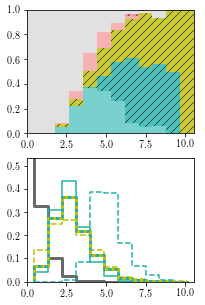

In [6]:
fig, ax = plt.subplots(2,1, figsize=(3,5))

plotit(ax[0], out_stats_sfr_z3p95_r10_dc10, axb=ax[1], N=18, clim=0.5, plim=0.5)

Eample without bottom axis

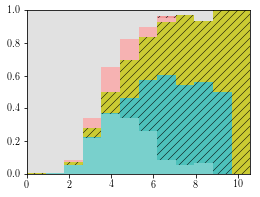

In [7]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

plotit(ax, out_stats_sfr_z3p95_r10_dc10, axb=None, N=18, clim=0.5, plim=0.5)

## Paper figures

Figure 6

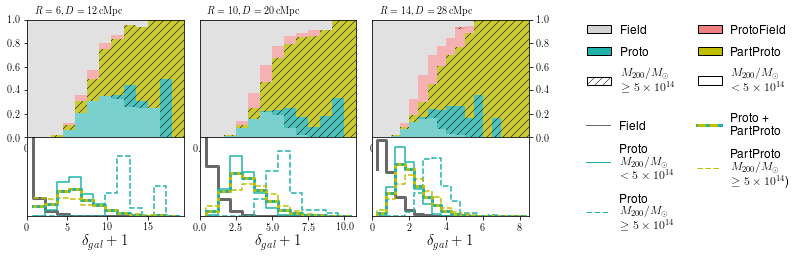

In [8]:
fig = plt.figure(figsize=(9, 13))

gs1 = gridspec.GridSpec(18, 3)
gs1.update(wspace=0.1, hspace=0)

ax1 = fig.add_subplot(gs1[0:3,0])
ax1b = fig.add_subplot(gs1[3:5,0])

ax2 = fig.add_subplot(gs1[0:3,1])
ax2b = fig.add_subplot(gs1[3:5,1])

ax3 = fig.add_subplot(gs1[0:3,2])
ax3b = fig.add_subplot(gs1[3:5,2])

N = 19

plotit(ax1, out_stats_sfr_z3p95_r6_dc6, axb=ax1b, N=N, clim=0.4, plim=0.8)
ax1.text(0.05,1.05,'$R = 6, D = 12 \,\mathrm{cMpc}$', transform=ax1.transAxes)

plotit(ax2, out_stats_sfr_z3p95_r10_dc10, axb=ax2b, N=N, clim=0.7, plim=0.6)
ax2.text(0.05,1.05,'$R = 10, D = 20 \,\mathrm{cMpc}$', transform=ax2.transAxes)

plotit(ax3, out_stats_sfr_z3p95_r14_dc14, axb=ax3b, N=N, clim=0.8, plim=0.4)
ax3.text(0.05,1.05,'$R = 14, D = 28 \,\mathrm{cMpc}$', transform=ax3.transAxes)

ax3.yaxis.tick_right()
ax3b.yaxis.tick_right()

ax2.set_yticks([])
for ax in ([ax1b,ax2b,ax3b]):
    ax.set_yticks([])
    ax.set_xlabel('$\delta_{gal} + 1$', size=15)
    

# Legend 1
pat1 = mpatches.Patch(color='lightgrey',label='Field')
pat2 = mpatches.Patch(color='lightseagreen',label='Proto')
pat3 = mpatches.Patch(color='lightcoral',label='ProtoField')
pat4 = mpatches.Patch(color='y',label='PartProto')
patM1 = mpatches.Patch(color='white', hatch='///',label='$M_{200} / M_{\odot}$ \n $\geq 5 \\times 10^{14}$')
patM2 = mpatches.Patch(color='white', hatch='',label='$M_{200} / M_{\odot}$ \n $< 5 \\times 10^{14}$')
colors = ['dimgrey','lightseagreen','lightcoral', 'y']
    
legend = ax3.legend(handles = [pat1,pat2,patM1,pat3,pat4,patM2], bbox_to_anchor=(1.3, 1.05),
                    ncol=2, prop={'size': 12}, labelspacing=0.9)

legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')

for patch in legend.get_patches():
    patch.set_edgecolor('black')
    

# Legend 2
line_field = plt.Line2D((0,1.5),(0,0), color='dimgrey', linestyle='solid', linewidth=1)
line_proto1 = plt.Line2D((0,1.5),(0,0), color='lightseagreen', linestyle='solid', linewidth=1)
line_proto2= plt.Line2D((0,1.5),(0,0), color='lightseagreen', linestyle='dashed', linewidth=1)
line_part = plt.Line2D((0,1.5),(0,0), color='y', linestyle='dashed', linewidth=1)

line_comb1 = plt.Line2D((0,1.5),(0,0), color='lightseagreen', linestyle='solid', linewidth=3)
line_comb2 = plt.Line2D((0,1.5),(0,0), color='y', linestyle='dashed', linewidth=3)

legend = ax3b.legend(handles = [line_field,line_proto1,line_proto2,(line_comb1, line_comb2),line_part],
                     labels=['Field','Proto \n $M_{200} / M_{\odot}$\n$< 5 \\times 10^{14}$',
                             'Proto \n$M_{200} / M_{\odot}$\n$\geq 5 \\times 10^{14}$',
                              'Proto + \n PartProto',
                            'PartProto \n$M_{200} / M_{\odot}$\n$\geq 5 \\times 10^{14}$)'],
                     bbox_to_anchor=(2.72, 1.45), ncol=2, prop={'size': 12}, labelspacing=1.0)

legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')

# plt.savefig(out_directory+'probabilities_A.png', bbox_inches='tight', dpi=300)

Appendix figure

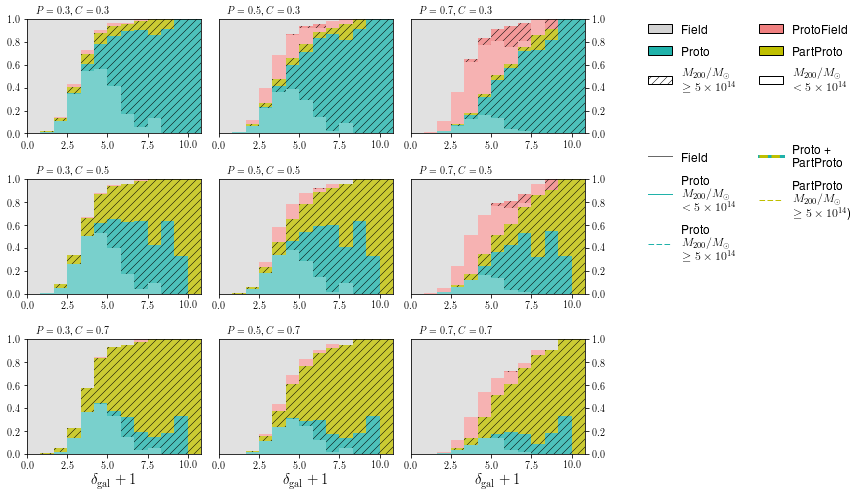

In [10]:
fig = plt.figure(figsize=(10, 8))

gs = gridspec.GridSpec(3, 3)
gs.update(wspace=0.1, hspace=0.4) # bottom = 0.57, top = 1, , wspace=0

N = 19

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

for clim, ax in zip([0.3, 0.5, 0.7], [ax1,ax2,ax3]):
    plotit(ax, out_stats_sfr_z3p95_r10_dc10, plim=0.3, clim=clim, N=N)
    ax.text(0.05,1.05,'$P = 0.3$, $C = %s$'%clim, transform=ax.transAxes)
    

ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[2,1])

for clim, ax in zip([0.3, 0.5, 0.7], [ax4, ax5, ax6]):
    plotit(ax, out_stats_sfr_z3p95_r10_dc10, plim=0.5, clim=clim, N=N)
    ax.text(0.05,1.05,'$P = 0.5$, $C = %s$'%clim, transform=ax.transAxes)
    ax.set_yticks([])
    

ax7 = fig.add_subplot(gs[0,2])
ax8 = fig.add_subplot(gs[1,2])
ax9 = fig.add_subplot(gs[2,2])

for clim, ax in zip([0.3, 0.5, 0.7], [ax7, ax8, ax9]):
    plotit(ax, out_stats_sfr_z3p95_r10_dc10, plim=0.7, clim=clim, N=N)
    ax.text(0.05,1.05,'$P = 0.7$, $C = %s$'%clim, transform=ax.transAxes)
    ax.yaxis.tick_right()
    

for ax in [ax3, ax6, ax9]:
    ax.set_xlabel('$\delta_{\mathrm{gal}} + 1$', size=15)


# Legend
pat1 = mpatches.Patch(color='lightgrey',label='Field')
pat2 = mpatches.Patch(color='lightseagreen',label='Proto')
pat3 = mpatches.Patch(color='lightcoral',label='ProtoField')
pat4 = mpatches.Patch(color='y',label='PartProto')
patM1 = mpatches.Patch(color='white', hatch='///',label='$M_{200} / M_{\odot}$ \n $\geq 5 \\times 10^{14}$')
patM2 = mpatches.Patch(color='white', hatch='',label='$M_{200} / M_{\odot}$ \n $< 5 \\times 10^{14}$')
colors = ['dimgrey','lightseagreen','lightcoral', 'y']
    
legend = ax7.legend(handles = [pat1,pat2,patM1,pat3,pat4,patM2], bbox_to_anchor=(1.3, 1.05),
                    ncol=2, prop={'size': 12}, labelspacing=0.9)

legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')

for patch in legend.get_patches():
    patch.set_edgecolor('black')
    
# Legend
line_field = plt.Line2D((0,1.5),(0,0), color='dimgrey', linestyle='solid', linewidth=1)
line_proto1 = plt.Line2D((0,1.5),(0,0), color='lightseagreen', linestyle='solid', linewidth=1)
line_proto2= plt.Line2D((0,1.5),(0,0), color='lightseagreen', linestyle='dashed', linewidth=1)
line_part = plt.Line2D((0,1.5),(0,0), color='y', linestyle='dashed', linewidth=1)

line_comb1 = plt.Line2D((0,1.5),(0,0), color='lightseagreen', linestyle='solid', linewidth=3)
line_comb2 = plt.Line2D((0,1.5),(0,0), color='y', linestyle='dashed', linewidth=3)

legend = ax8.legend(handles = [line_field,line_proto1,line_proto2,(line_comb1, line_comb2),line_part],
                     labels=['Field','Proto \n $M_{200} / M_{\odot}$\n$< 5 \\times 10^{14}$',
                             'Proto \n$M_{200} / M_{\odot}$\n$\geq 5 \\times 10^{14}$',
                              'Proto + \n PartProto',
                            'PartProto \n$M_{200} / M_{\odot}$\n$\geq 5 \\times 10^{14}$)'],
                     bbox_to_anchor=(1.3, 1.4), ncol=2, prop={'size': 12}, labelspacing=1.0)

legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')
    
# plt.savefig(out_directory+'probabilities_C.png', bbox_inches='tight', dpi=300)

Deprecated

In [ ]:
fig = plt.figure(figsize=(5, 12))

gs = gridspec.GridSpec(19, 2)
gs.update(wspace=0.1, hspace=0)

ax1 = fig.add_subplot(gs[0:3,0])
ax1b = fig.add_subplot(gs[3:5,0])

ax2 = fig.add_subplot(gs[0:3,1])
ax2b = fig.add_subplot(gs[3:5,1])

ax3 = fig.add_subplot(gs[7:10,0])
ax3b = fig.add_subplot(gs[10:12,0])

ax4 = fig.add_subplot(gs[7:10,1])
ax4b = fig.add_subplot(gs[10:12,1])

ax5 = fig.add_subplot(gs[14:17,0])
ax5b = fig.add_subplot(gs[17:19,0])

ax6 = fig.add_subplot(gs[14:17,1])
ax6b = fig.add_subplot(gs[17:19,1])

N = 19

plotit(ax1, out_stats_sfr_z3p95_r6_dc14, axb=ax1b, N=N, clim=0.6, plim=0.4)
ax1.text(0.05,1.05,'$R = 6, D/2 = 14 \,\mathrm{cMpc}$', transform=ax1.transAxes, size=10)

plotit(ax2, out_stats_sfr_z3p95_r10_dc14, axb=ax2b, N=N, clim=0.6, plim=0.4)
ax2.text(0.05,1.05,'$R = 10, D/2 = 14\,\mathrm{cMpc}$', transform=ax2.transAxes, size=10)

plotit(ax3, out_stats_sfr_z3p10_r10_dc10, clim=0.6, plim=0.3, N=N, axb = ax3b)
ax3.text(0.05,1.05,'$z = 3.10$', transform=ax3.transAxes, size=12)

plotit(ax4, out_stats_sfr_z5p03_r10_dc10, clim=0.7, plim=0.6, N=N, axb = ax4b)
ax4.text(0.05,1.05,'$z = 5.92$', transform=ax4.transAxes, size=12)

plotit(ax5, out_stats_mstar_z2p07_r10_dc10, N=N, clim=0.8, plim=0.4, axb=ax5b)
ax5.text(0.05,1.05,'$\mathrm{S}_9$', transform=ax5.transAxes, size=12)

plotit(ax6, out_stats_mstar10_z2p07_r10_dc10, N=N, clim=0.8, plim=0.5, axb=ax6b)
ax6.text(0.05,1.05,'$\mathrm{S}_{10}$', transform=ax6.transAxes, size=12)


for ax in [ax2,ax4,ax6]:
    ax.yaxis.tick_right()
    
for ax in [ax1b,ax2b,ax3b,ax4b,ax5b,ax6b]:
    ax.set_yticks([])
    ax.set_xlabel('$\delta_{\mathrm{gal}} + 1$', size=15)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set_xticklabels([])


# plt.savefig(out_directory+'probabilities_depth.png', bbox_inches='tight', dpi=300)